In [1]:
import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *

'''def timing():
    start_time = timeit.default_timer()
    #start_time = time.time()
    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))
    y = '{:.10f}s #'.format(timeit.default_timer() - start_time)
    return lambda x: print(f"\n#{len(y+x)*'='}#\n# {x}{y}\n#{len(y+x)*'='}#\n")
t = timing()
t("Execution time: ")'''
# tai from ... import *

'def timing():\n    start_time = timeit.default_timer()\n    #start_time = time.time()\n    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))\n    y = \'{:.10f}s #\'.format(timeit.default_timer() - start_time)\n    return lambda x: print(f"\n#{len(y+x)*\'=\'}#\n# {x}{y}\n#{len(y+x)*\'=\'}#\n")\nt = timing()\nt("Execution time: ")'

In [51]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

# Database query

In [2]:
df = database_query("SELECT * FROM SensorData limit 50000")
df.head()

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Histogram of x and y coordinates

x mean:  1959.85514
y mean:  570.94314
x std:  878.0638038978605
y std:  1028.422147713156


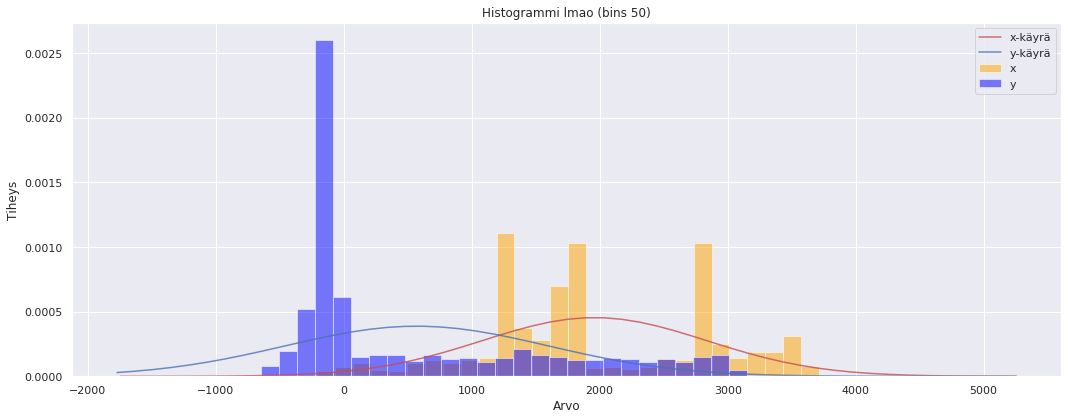

CPU times: user 1.63 s, sys: 86.1 ms, total: 1.71 s
Wall time: 755 ms


In [3]:
%%time
draw_histogram(df['x'], df['y'], 50)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in node_id: 1
uniques in timestamp: 50000
uniques in x: 3923
uniques in y: 3955
uniques in z: 1
uniques in q: 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 1
------------------------------
Outliers

Data with outliers:  50000
Ouliers removed:     148
Data after:          49852
Percent removed:    0.3 %
Percent remaining:  99.7 %
------------------------------
CPU times: user 331 ms, sys: 12 ms, total: 343 ms
Wall time: 342 ms


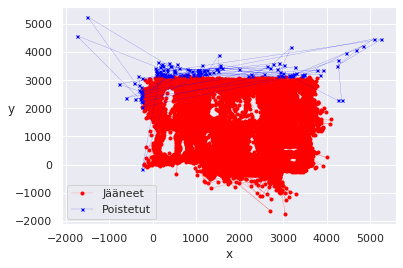

In [4]:
%%time
df1 = find_outliers(df)

Koko datasetissä (13 890 906)
- Data with outliers: 13 890 906
- Ouliers removed:    376 791
- Data after:         13 514 115

In [5]:
def clean_dataframe(df):
    
    # node_id:s to 1-32 format
    df['node_id'] = pd.factorize(df['node_id'])[0] + 1
    
    # Timestamp to datetime
    df['timestamp'] = df['timestamp'].astype(str)
    df['timestamp'] = df['timestamp'].str.slice(2, -7)
    df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    
    # Round ms
    df.timestamp = df.timestamp.dt.round("ms")
    df.timestamp = df.timestamp.dt.tz_localize('UTC')

    # Muunnetaan Suomen aikaan. Tämä huomioi kesä- ja talviajan.
    df.timestamp = df.timestamp.dt.tz_convert('Europe/Helsinki')
    
    # Drop +00 ending
    df['timestamp'] = df['timestamp'].astype(str)
    df['timestamp'] = df['timestamp'].str.slice(0, -7)
    df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
    
    # viikonpäiväkolumni
    df['dayofweek'] = df.timestamp.dt.dayofweek
    
    print(df.timestamp.dt.hour.unique())
    print(f"{'-'*30}\nFiltering out after-hours\n")
    print("Data before filtering: ", len(df))
    print("Deleted nodes before 8:00: ",len(df) - len(df.drop(df[(df.timestamp.dt.hour < 8)].index)))
    print("Deleted nodes after 21:00: ", len(df) - len(df.drop(df[(df.timestamp.dt.hour > 21)].index)))
    print("Deleted after-hours nodes: ", (len(df.drop(df[(df.timestamp.dt.hour < 8)].index)) + len(df.drop(df[(df.timestamp.dt.hour > 21)].index))))
    # Poistetaan aukioloaikojen ulkopuolella olevat ajat
    df = df.drop(df[(df.timestamp.dt.hour < 8)].index) #dropataan kaikki 8-21 ulkopuolella olevat tunnit
    df = df.drop(df[(df.timestamp.dt.hour > 21)].index)
    df = df.reset_index(drop=True) # resetoidaan indexit, että voidaan ajaa uudet koodit
    
    # alustetaan uusi kolumni nollalla, tähän tulee kyseinen tunti kaupassa, esimerkiksi klo 8 eli aukioloajan ensimmäinen tunti on 1
    df['current_hour'] = 0
    
    # Käydään läpi timestamp ja jokaikisen tunnin kohdalle lisätään yksi tunti. Aloitetaan tunnista 8
    #Koska 8-21 välillä 15 tuntia, ajetaan tämä 15 kertaa
    for i in range(15):
        df['current_hour'].loc[df['timestamp'].dt.hour == 8+i] = i+1

    #Sunnuntaina aloitetaan kaksi tuntia myöhemmin, joten vähennetään kaksi tuntia jokaisesta hetkestä
    df['current_hour'].loc[df['timestamp'].dt.dayofweek == 6] = df['current_hour'].loc[df['timestamp'].dt.dayofweek == 6] - 2
    
    # Suodatetaan Sunnuntaitten aukioloajat
    df_temp = df[df.timestamp.dt.dayofweek == 6].index.values.tolist()
    df_new_temp = df.iloc[df_temp][df.iloc[df_temp].timestamp.dt.hour < 10]

    # Poistetaan alkuperäisestä dataframesta kyseiset arvot
    df = df.drop(df.index[df_new_temp.index.values])
    
    df = df.reset_index(drop=True)
    
    # Drop z and q columns
    df = df.drop(columns=['z','q'])
    
    bad_nodes = [13,14,18,27,32]
    
    # Poistetaan huonot nodet
    print(f"{'-'*30}\nBad nodes: {bad_nodes}\n")
    print("Amount of bad nodes", (len(df[df.node_id == 13]) + len(df[df.node_id == 14]) + len(df[df.node_id == 18]) + len(df[df.node_id == 27]) + len(df[df.node_id == 32])))
    print("Data after deleting bad nodes: ", len(df) - (len(df[df.node_id == 13]) + len(df[df.node_id == 14]) + len(df[df.node_id == 18]) + len(df[df.node_id == 27]) + len(df[df.node_id == 32])))
    print(f"{'-'*30}")
    df = df[df.node_id != 13]
    df = df[df.node_id != 14]
    df = df[df.node_id != 18]
    df = df[df.node_id != 27]
    df = df[df.node_id != 32]
    
    return df

clean_dataframe(df1)

[15  7  8  9 10 11 12 13 16 17 18 19 20 14  6 21  5]
------------------------------
Filtering out after-hours

Data before filtering:  49852
Deleted nodes before 8:00:  2324
Deleted nodes after 21:00:  0
Deleted after-hours nodes:  97380
------------------------------
Bad nodes: [13, 14, 18, 27, 32]

Amount of bad nodes 0
Data after deleting bad nodes:  47528
------------------------------


,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8
...,...,...,...,...,...,...
47523,1,2020-07-07 16:36:08.795,1277,-71,1,9
47524,1,2020-07-07 16:36:18.795,1278,-77,1,9
47525,1,2020-07-07 16:36:27.795,1277,-80,1,9
47526,1,2020-07-07 16:36:38.793,1273,-85,1,9


# Cleaning Node_id, timestamp, q, z columns

In [5]:
df1 = clean_dataframe(df1)
df1

[15  7  8  9 10 11 12 13 16 17 18 19 20 14  6 21  5]
------------------------------
Filtering out after-hours

Data before filtering:  49852
Deleted nodes before 8:00:  2324
Deleted nodes after 21:00:  0
Deleted after-hours nodes:  97380
------------------------------
Bad nodes: [13, 14, 18, 27, 32]

Amount of bad nodes 0
Data after deleting bad nodes:  47528
------------------------------


,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8
...,...,...,...,...,...,...
47523,1,2020-07-07 16:36:08.795,1277,-71,1,9
47524,1,2020-07-07 16:36:18.795,1278,-77,1,9
47525,1,2020-07-07 16:36:27.795,1277,-80,1,9
47526,1,2020-07-07 16:36:38.793,1273,-85,1,9


# Katsotaan kuinka paljon kutakin nodea on käytetty

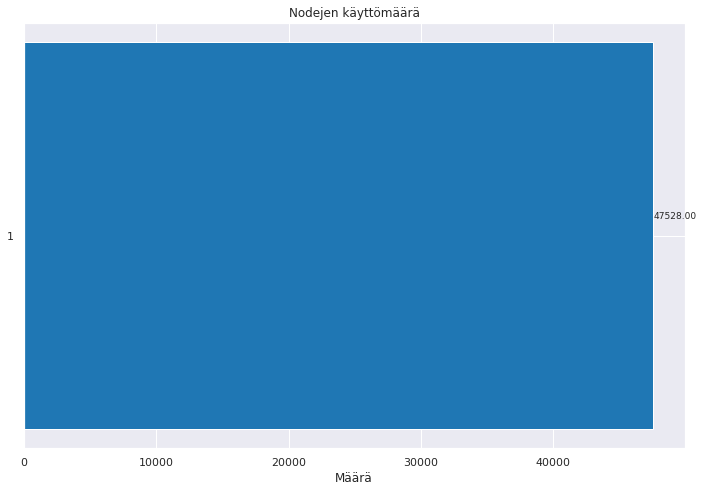

In [6]:
draw_node_amount(df1, 'node_id')

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

Dataframe lenght before: 47528
Dataframe lenght after: 47385
Total outliers detected: 143
Percent removed:    0.3 %
Percent remaining:  99.7 %


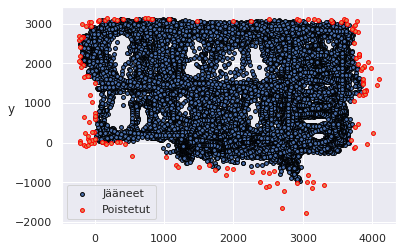

node numero 1 valmis
CPU times: user 7.76 s, sys: 253 ms, total: 8.02 s
Wall time: 6.97 s


,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8


In [7]:
%%time
for i in range(len(df1.node_id.unique())):
    df1 = isolation_forest(df1, 0, .003, i+1)
    print('node numero', i+1, 'valmis')
    
    if i == 0:
        df1.to_csv('./temp_data.csv', index=False)
    else:
        df1.to_csv('./temp_data.csv',mode='a', header=False, index=False)
        
'''df2 = pd.read_csv('./temp_data.csv')
import os
os.remove("./temp_data.csv")
df2.head()'''
df1.head()

# Adding xy_grid values to dataframe (50x50)

In [8]:
%%time
grid_size = 40
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
print(df1)

       node_id               timestamp     x    y  dayofweek  current_hour  \
0            1 2020-06-24 15:20:08.533  2762 -257          2             8   
1            1 2020-06-24 15:20:08.620  2870 -344          2             8   
2            1 2020-06-24 15:20:09.623  2916 -344          2             8   
3            1 2020-06-24 15:20:09.623  2894 -254          2             8   
4            1 2020-06-24 15:20:10.116  2888 -188          2             8   
...        ...                     ...   ...  ...        ...           ...   
47380        1 2020-07-07 16:36:08.795  1277  -71          1             9   
47381        1 2020-07-07 16:36:18.795  1278  -77          1             9   
47382        1 2020-07-07 16:36:27.795  1277  -80          1             9   
47383        1 2020-07-07 16:36:38.793  1273  -85          1             9   
47384        1 2020-07-07 16:36:47.793  1272  -86          1             9   

       x_grid  y_grid  grid_id  
0          29       7      309

# Find and draw exits

# Poistetaan liiat nopeudet

In [9]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter


class velocity():
    """[Luokalla "velocity" on 4 funktiota: calc_timejump, calculateDistance, column_vel & draw_vel]
    """
    # Nopeuden laskun funktio
    def calc_timejump(time_start, time_end):
        """[Laskee kuinka paljon aikaa on kulunut lähdetystä timestampista toiseen.]

        Args:
            time_start ([timestamp]): [Timestamp, mistä lähdetään liikkelle]
            time_end ([timestamp]): [Timestamp, mihin päädytään] 
        """
        # Lasketaan aloitus- ja lopetusajan erotus
        diff_time = np.datetime64(time_start) - np.datetime64(time_end)
        # Palauttaa sekuntien kokonaismäärän
        # Tosin palauttaa microsekunneksi
        diff_time.item().total_seconds()
        # Muuttaa sekunneiksi
        diff_time = diff_time / np.timedelta64(1, 's')

        # Pudottaa jo tässä vaiheessa tosi pienet ajat
        if(diff_time > 0.1):
            return diff_time
        else:
            return 0.1
        
    def calculateDistance(x1, y1, x2, y2): 
        """[Laskee euklidisen normin sqrt(x * x + y * y) Tämä on vektorin pituus origosta pisteeseen]

        Args:
            x1 ([int]): [x kolumnin arvo, jota käsitellään]
            x2 ([int]): [x kolumnin arvo seuraavana x1:sestä]
            y1 ([int]): [y kolumnin arvo, jota käsitellään]
            y2 ([int]): [y kolumnin arvo seuraavana y1:sestä]
            
        Returns:
            [float]: [Palauttaa euclidisen pituuden datapisteiden välillä]
        """
        dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
        return dist

    def column_vel(df, x_sarake, y_sarake):
        """[Laskee datapisteiden välisen nopeuden]

        Args:
            df ([DataFrame]): [Taulu, jota halutaan käsitellä. Vaatii sarakkeet 'x', 'y' & 'timestamp']
            x_sarake ([string]): [Sarake, missä x koordinaatit]
            y_sarake ([string]): [Sarake, missä y koordinaatit]
            
        Returns:
            mergedDf ([DataFrame]): [Alkuperäinen syötetty taulu, johon on lisätty 'velocity' ja 'distance' sarakkeet]
        """
        # Alustaa muuttujia
        df_original = df.copy()
        devx1 = []
        time = []
        dist = []
        speed = []
        # x ja y kolumnin indexi
        x_column = df.columns.get_loc(x_sarake)
        y_column = df.columns.get_loc(y_sarake)
        # timestampin indexi
        time_column = df.columns.get_loc('timestamp')
        i = 1

        # Iteroidaan taulukon pituuden läpi
        for i in range(len(df[x_sarake])):
            # Ottaa timestamp kolumnista yhden ja sitä seuraavan arvon ja laskee niiden välisen nopeuden
            time.append(velocity.calc_timejump(df.iloc[i, time_column], df.iloc[i-1, time_column]))
            # Sama kuin ylemmässä, mutta lisätään iteroitavan y kolumnin mukaan ja laskeetaan niiden välisen pituuden
            dist.append(round(velocity.calculateDistance(abs(df.iloc[i, x_column]), abs(df.iloc[i, y_column]),abs(df.iloc[i-1, x_column]), abs(df.iloc[i-1, y_column])),1))

        # Lasketaan nopeus jakamalla pituus ajalla
        for i in range(len(dist)):
            speed.append((dist[i] / 100) / time[i])
            #speed.append((dist[i] / 93)/time[i])
        speed2 = speed
        dist2 = dist    
        
        x = 0
        
        # Poistetaan liiat nopeudet joko:
        # jos nopeus on liian suuri (yli 2 km/h)
        # jos on kulkenut liian pitkän matkan liian nopeasti (jos yli 100 pistettä)
        for i in speed:
            if(i > 5.0 or (dist[x]/100) > 100):
                df.drop([df.index[x]], axis = 0, inplace = True)
                x -= 1
            x += 1
        print("Vanha taulu: ", len(df_original))
        print("Uusi taulu: ", len(df['x'])) 
        print("Poistettuja pisteitä: ", len(df_original) - len(df))
        total_data = len(df_original)
        total_missing = len(df_original) - len(df)
        percentage = (total_missing/total_data) * 100
        percentage_remain = (1 - (total_missing/total_data)) * 100
        print("Percent removed:   ",round(percentage, 2),'%')
        print("Percent remaining: ",round(percentage_remain, 2),'%')
        print(f"{'-'*30}")
        # Luodaan taulu nopeuksista ja pituuksista
        s = pd.Series(dist)
        s = (s / 100).tolist()
        new_df = pd.DataFrame(list(zip(speed, s)),columns=['velocity_kmh', 'distance_m'])
        
        # Yhdistetään tämä taulu syötettyyn tauluun
        mergedDf = df.join(new_df)
        mergedDf
        
        return mergedDf, speed2, dist2
    
    def column_vel_GRID(df, x_sarake, y_sarake, speed2, dist2):
        """[Laskee datapisteiden välisen nopeuden]

        Args:
            df ([DataFrame]): [Taulu, jota halutaan käsitellä. Vaatii sarakkeet 'x', 'y' & 'timestamp']
            x_sarake ([string]): [Sarake, missä x koordinaatit]
            y_sarake ([string]): [Sarake, missä y koordinaatit]
            
        Returns:
            mergedDf ([DataFrame]): [Alkuperäinen syötetty taulu, johon on lisätty 'velocity' ja 'distance' sarakkeet]
        """
        # Alustaa muuttujia
        df_original = df.copy()
        devx1 = []
        time = []
        dist = []
        speed = []
        # x ja y kolumnin indexi
        x_column = df.columns.get_loc(x_sarake)
        y_column = df.columns.get_loc(y_sarake)
        # timestampin indexi
        time_column = df.columns.get_loc('timestamp')
        i = 1

        # Iteroidaan taulukon pituuden läpi
        for i in range(len(df[x_sarake])):
            # Ottaa timestamp kolumnista yhden ja sitä seuraavan arvon ja laskee niiden välisen nopeuden
            time.append(velocity.calc_timejump(df.iloc[i, time_column], df.iloc[i-1, time_column]))
            # Sama kuin ylemmässä, mutta lisätään iteroitavan y kolumnin mukaan ja laskeetaan niiden välisen pituuden
            dist.append(round(velocity.calculateDistance(abs(df.iloc[i, x_column]), abs(df.iloc[i, y_column]),abs(df.iloc[i-1, x_column]), abs(df.iloc[i-1, y_column])),1))

        # Lasketaan nopeus jakamalla pituus ajalla
        for i in range(len(dist)):
            speed.append((dist[i]) / time[i])
            #speed.append((dist[i] / 93)/time[i])
        #print([speed.count(x) for x in set(speed)])
        #print(Counter(speed))
        speed = speed2
        dist = dist2
        
        x = 0
        # Poistetaan liiat nopeudet joko:
        # jos nopeus on liian suuri (yli 2 km/h)
        # jos on kulkenut liian pitkän matkan liian nopeasti (jos yli 100 pistettä)
        '''for i in speed:
            #print(x)
            if(i > 5.0 or dist[x] > 10.0):
                df['Deleted']=df.index[x]==True
                df.drop([df.index[x]], axis=0, inplace = True)
                #print("Piste poistettud")
                x -= 1
            else:
                df['Deleted']=df.index[x]==False
                x -= 1
            x += 1'''
        for i in speed:
            if(i > 5.0 or dist[x] > 10):
                df.drop([df.index[x]], axis = 0, inplace = True)
                x -= 1
            x += 1
        print("Vanha taulu: ", len(df_original))
        print("Uusi taulu: ", len(df['x'])) 
        print("Poistettuja pisteitä: ", len(df_original) - len(df))
        total_data = len(df_original)
        total_missing = len(df_original) - len(df)
        percentage = (total_missing/total_data) * 100
        percentage_remain = (1 - (total_missing/total_data)) * 100
        print("Percent removed:   ",round(percentage, 2),'%')
        print("Percent remaining: ",round(percentage_remain, 2),'%')
        print(f"{'-'*30}")
        
        # Luodaan taulu nopeuksista ja pituuksista
        new_df = pd.DataFrame(list(zip(speed, dist)),columns=['velocity_kmh', 'distance_m'])
        
        # Yhdistetään tämä taulu syötettyyn tauluun
        mergedDf = df.join(new_df)
        mergedDf
        
        return mergedDf


    def draw_vel(df_original, df_new, columnX, columnY):
        """[Piirtää kuvaajan poistetuista (Musta) ja jääneistä (Cyan) pisteistä]

        Args:
            df_original ([DataFrame]): [Taulu ennen siivousta]
            df_new ([DataFrame]): [Taulu siivouksien jälkeen]
            columnX ([string]): [Koordinaattien x sarake]
            columnY ([string]): [Koordinaattien y sarake]
        """
        plt.figure(figsize=(10, 7))
        plt.plot(df_original[columnX], df_original[columnY], color="black", marker='o', linestyle='dashed', linewidth=0.2, markersize=3, label="Poistettu")
        plt.plot(df_new[columnX], df_new[columnY],color='cyan', markeredgecolor='deeppink', marker='o',linewidth=0.2, markersize=4, markevery=3, label="Jääneet")
        plt.ylabel("y", rotation='0')
        plt.xlabel("x")
        plt.grid()
        plt.title("Liiat nopeudet poistettu")
        plt.legend()
        plt.show()

In [138]:
%%time
# Otetaan kopio taulusta piirtämistä varten
dftest = df_reitit.copy()
# Laskee x:n ja y:n oudot nopeudet
uusi_df_grid = velocity.column_vel_GRID(dftest, 'x', 'y', speeds, distances)
# Piirtää kuvan näistä
velocity.draw_vel(df_reitit, uusi_df_grid, 'x', 'y')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [97]:
uusi_df_grid

,ajokerta,node_id,timestamp,x,y,grid_id,kesto,Deleted,velocity(km/h),distance(m)
469,11,1,2020-06-28 18:37:43.645,8,25,1008,0 days 02:53:14.998000,False,0.466667,1.4
469,29,1,2020-07-02 11:11:09.794,29,5,229,1 days 00:16:47.999000,False,0.466667,1.4
469,30,1,2020-07-02 20:29:47.794,15,34,1375,0 days 01:22:59,False,0.466667,1.4
469,55,1,2020-07-06 20:21:34.793,2,28,1122,0 days 16:00:30.001000,False,0.466667,1.4
470,11,1,2020-06-28 18:37:44.645,8,25,1008,0 days 02:53:14.998000,False,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
918,29,1,2020-07-02 19:07:08.793,19,13,539,1 days 00:16:47.999000,False,1.401401,1.4
919,29,1,2020-07-02 19:07:09.793,18,13,538,1 days 00:16:47.999000,False,0.000000,0.0
920,29,1,2020-07-02 19:07:10.794,18,14,578,1 days 00:16:47.999000,False,2.197802,2.2
921,29,1,2020-07-02 19:07:10.794,17,14,577,1 days 00:16:47.999000,False,1.000000,1.0


Vanha taulu:  47385
Uusi taulu:  44570
Poistettuja pisteitä:  2815
Percent removed:    5.94 %
Percent remaining:  94.06 %
------------------------------


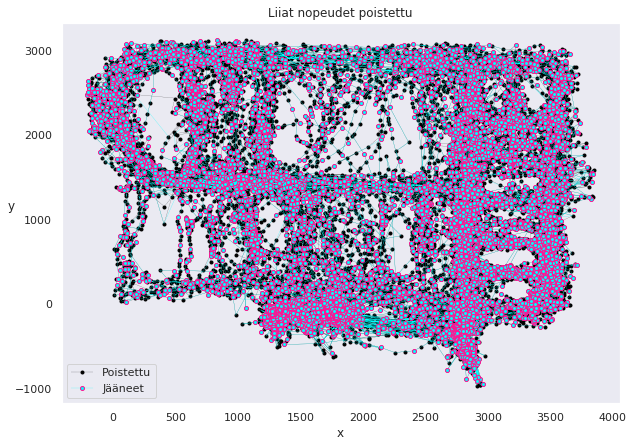

CPU times: user 9.62 s, sys: 3.85 ms, total: 9.62 s
Wall time: 9.62 s


In [10]:
%%time
# Otetaan kopio taulusta piirtämistä varten
dftest = df1.copy()
# Laskee x:n ja y:n oudot nopeudet
uusi_df, speeds, distances = velocity.column_vel(dftest, 'x', 'y')
# Piirtää kuvan näistä
velocity.draw_vel(df1, uusi_df, 'x', 'y')

In [12]:
x_cut = pd.cut(uusi_df['distance_m'], 40,labels=False)
# Laitetaan saadut arvot dataframeen
uusi_df['distance_grid'] = x_cut.values
# Laitetaan arvot dataframeen, xygridiID = y * gridsize +x
#uusi_df['test'] = uusi_df['test'] * 40 + uusi_df['test']
uusi_df

,node_id,timestamp,x,y,dayofweek,current_hour,x_grid,y_grid,grid_id,velocity_kmh,distance_m,distance_grid
2,1,2020-06-24 15:20:09.623,2916,-344,2,8,30,6,270,0.458624,0.460,0
4,1,2020-06-24 15:20:10.116,2888,-188,2,8,30,7,310,1.344828,0.663,1
5,1,2020-06-24 15:20:11.086,2910,-200,2,8,30,7,310,0.258763,0.251,0
6,1,2020-06-24 15:20:11.820,2924,-111,2,8,30,8,350,1.227520,0.901,1
7,1,2020-06-24 15:20:12.995,2928,5,2,8,30,9,390,0.902979,1.061,1
...,...,...,...,...,...,...,...,...,...,...,...,...
47380,1,2020-07-07 16:36:08.795,1277,-71,1,9,14,8,334,0.003110,0.028,0
47381,1,2020-07-07 16:36:18.795,1278,-77,1,9,14,8,334,0.006100,0.061,0
47382,1,2020-07-07 16:36:27.795,1277,-80,1,9,14,8,334,0.003556,0.032,0
47383,1,2020-07-07 16:36:38.793,1273,-85,1,9,14,8,334,0.005819,0.064,0


In [13]:
uusi_df['distance_grid'].unique()

array([ 0,  1,  2,  5,  3,  8, 12,  4, 11,  6,  7, 13, 10, 39, 18,  9, 14,
       16, 15, 17, 21, 28])

In [14]:
df1 = uusi_df.copy()

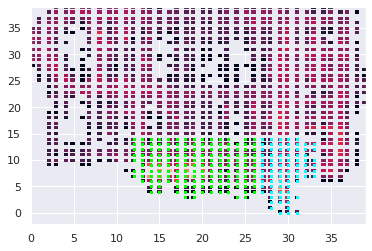

CPU times: user 1.3 s, sys: 96.1 ms, total: 1.39 s
Wall time: 416 ms


In [15]:
%%time
in_x, in_y = sisään(df1, 'x_grid', 'y_grid')
out_x, out_y = ulos(df1, 'x_grid', 'y_grid')

draw_exits(df1, in_x, in_y, out_x, out_y, 'x_grid', 'y_grid')

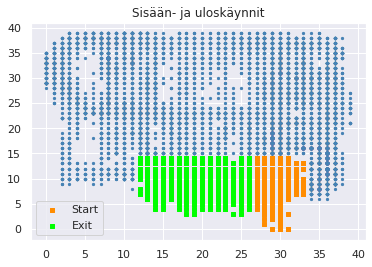

CPU times: user 2.14 s, sys: 148 ms, total: 2.28 s
Wall time: 1.08 s


In [16]:
%%time
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
grid_size = 40
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Voidaan tarkistaa sijaintien oikeellisuus
'''sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)'''
plt.scatter(df1['x_grid'], df1['y_grid'], color='steelblue', s=5)#np.random.random(3)
plt.scatter(in_x, in_y, color='darkorange', marker='s', s=10, label="Start")
plt.scatter(out_x, out_y, color='lime', marker='s', s=10, label="Exit")
plt.title("Sisään- ja uloskäynnit")
plt.legend()

plt.show()

### Erotetaan kauppareissut toisistaan

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set();

class Reitti:
    """[Objektiin tallennetaan yksittäisen reitin tiedot]
    """
    def __init__(self):
        """[Jokaiselle tallennettavalle tiedolle luodaan oma lista, kun objekti luodaan]
        """
        self.ajokerta = []
        self.node_id = []
        self.timestamp = []
        self.ID = []
        self.x = []
        self.y = []
        self.velocity_kmh = []
        self.distance_grid = []
      

    def lisaa(self,ajokerta, node_id, timestamp, ID, x, y, vel, dist):
        """[Lisätään kerättävät tiedot objektin listoihin.]

        Args:
            ajokerta ([list]): [yksittäisen reitin id]
            node_id ([list]): [yksittäisen reitin node_id]
            timestamp ([list]): [yksittäisen reitin timestampit]
            ID ([list]): [yksittäisen reitin kulkemat ID:t]
            x ([list]): [yksittäisen reitin x-koordinaatit]
            y ([list]): [yksittäisen reitin y-koordinaatit]
        """
        self.ajokerta.append(ajokerta)
        self.node_id.append(node_id)
        self.timestamp.append(timestamp)
        self.ID.append(ID)
        self.x.append(x)
        self.y.append(y)
        self.velocity_kmh.append(vel)
        self.distance_grid.append(dist)


def poista_lyhyet_reitit(reitit, minimi_määrä_dataa):
    """[Poistaa kauppareissut, joissa annettua arvoa pienempi määrä dataa.]

    Args:
        reitit ([list]): [Sisältää kauppareissu-objektit]
        minimi_m ([int]): [Vähittäismäärä datapisteita objektissa.]

    Returns:
        [list]: [Palauttaa listan, jossa tarpeeksi datapisteitä sisältävät kauppareissut.]
    """
    clean_list = []
    for i in range(len(reitit)):
        if len(reitit[i].node_id) > minimi_määrä_dataa:
            clean_list.append(reitit[i])
    return clean_list

        
def erottele_reitit(df, in_ID, out_ID):
    """[Iteroi jokaisen dataframen rivin, tutkii milloin uusi kauppareissu alkaa ja lisää reissun tiedot sille luotuun objektiin.]

    Args:
        df ([DataFrame]): [Diskretisoitu dataframe]
        in_ID ([list]): [Sisäänkäyntialueen diskretisoidut koordinaatit ID-muodossa.]
        out_ID ([list]): [Kassa-alueen diskretisoidut koordinaatit ID-muodossa.]

    Returns:
        [list]: [Sisältää yksittäisten reittien objektit.]
    """
    
    # Luodaan dataframeen sarakkeet, joilla seurataan onko rivin paikkakoordinaatit kassa- tai sisäänkäyntialueilla.
    df["IN"] = df["grid_id"].isin(in_ID)
    df["OUT"] = df["grid_id"].isin(out_ID)

    # Näiden avulla seurataan, että useampi peräkkäinen rivi on kassa- tai sisäänkäyntialueilla.
    df['fo_IN'] = df['IN'].shift(5)
    df['fo_OUT'] = df['OUT'].shift(10)

    cleaned_xy = df.copy()
    erotellut_reitit = []      #tähän tallennetaan erotellut kauppareissut
    ajokerta = 0   # pidetään kirjaa kuinka monta kertaa kärry on ajanut kaupan läpi. Käytetään Kärryjen etsimiseen ja erotteluun
    reitti = Reitti()      #luodaan karry
    erotellut_reitit.append(reitti)     #lisätään ensimmäinen karry listaan, koska data alkaa yleensä kesken ajokerran 
    matkalla = False    

    
    for row in df.itertuples():
        
        if matkalla == False and row.IN  == True and row.IN == row.fo_IN:
            # Aloitetaan matka ja luodaan uusi olio kaupparaissulle.
            matkalla = True
            ajokerta += 1
            reitti = Reitti()      
            erotellut_reitit.append(reitti)

        elif row.OUT == True and row.OUT == row.fo_OUT:
            matkalla = False
        
        elif matkalla == True:
            erotellut_reitit[ajokerta].lisaa(ajokerta,row.node_id, row.timestamp,row.grid_id, row.x_grid, row.y_grid, row.velocity_kmh, row.distance_grid)
    
    return erotellut_reitit

def reitit_dataframeksi(reitit):
    """[Luo dataframen, joka sisältää kaikkien kauppareissujen tiedot.]

    Args:
        reitit ([List]): [Sisältää kauppareissu-oliot]

    Returns:
        [DataFrame]: [Palauttaa Dataframen, joka sisältää jokaisen datasta erotellun kauppareissun.]
    """

    kauppareissut = pd.DataFrame()
    reitt = []
    kauppareissut = kauppareissut.append([pd.DataFrame({"ajokerta":a.ajokerta,
                                                        "node_id":a.node_id,
                                                        "timestamp":a.timestamp,
                                                        "x":a.x,
                                                        "y":a.y,
                                                        "grid_id":a.ID,
                                                        "velocity_kmh":a.velocity_kmh,
                                                        "distance_grid":a.distance_grid,
                                                        "kesto":a.timestamp[-1]-a.timestamp[0] }) for a in reitit])
    return kauppareissut

def plot_all_routes(df_reitit, grid_size):
    """Plottaa kaikki erotellut reitit samaan kuvaajaan]

    Args:
        df_reitit ([DataFrane]): [Sisältää erotellut reitit]
        grid_size ([int]): [Gridin koko on määritelty arvon mukaan.]
    """
    facet = sns.scatterplot(x="x", y="y", data=df_reitit, hue="ajokerta")
    facet.set_xticks(np.arange(0, grid_size+1,10))
    facet.set_yticks(np.arange(0, grid_size+1,10))
    plt.show()

def plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y):
    """[Plottaa jokaisen kauppareissun peräkkäin]

     Args:
         df_reitit ([DataFrame]): [Sisältää erotellut kauppareitit]
         grid_size ([int]): [Gridin koko on määritelty tämän mukaan.]
     """
    
    ajot = df_reitit["ajokerta"].unique()
    df_reitit["color"] = np.arange(0,len(df_reitit),1)
    for ajo in ajot:
        print(len(df_reitit[df_reitit["ajokerta"] == ajo]))

        facet = sns.scatterplot(x="x", y="y", data=df_reitit[df_reitit["ajokerta"] == ajo],  hue="color")
        sns.scatterplot(x=in_x, y=in_y)
        sns.scatterplot(x=out_x, y=out_y)
        facet.set_xticks(np.arange(0, grid_size+1,10))
        facet.set_yticks(np.arange(0, grid_size+1,10))
        plt.legend([],[], frameon=False)
        plt.show()
        
def get_lapimeno(reitit, minimi_määrä_dataa):        

    alo = []
    lapimenoajat = [] #Luodaan pari uutta listaa
        

    
    for i in range(len(reitit)):
        if len(reitit[i].node_id) > minimi_määrä_dataa:
            alotus = reitit[i].timestamp[0]
            lopetus = reitit[i].timestamp[-1]
            lapimenoaika = (lopetus - alotus)
            alo.append(alotus)
            lapimenoajat.append(lapimenoaika)  #For looppi missä saadaan luotua läpimenoajat kärryille
    
    
    return alo, lapimenoajat

In [25]:
%%time
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)

CPU times: user 424 ms, sys: 122 µs, total: 424 ms
Wall time: 423 ms


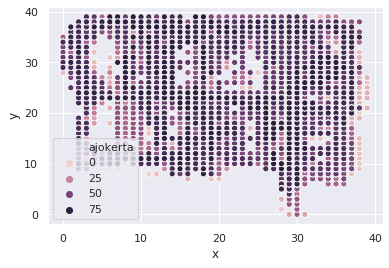

CPU times: user 2.35 s, sys: 64.5 ms, total: 2.41 s
Wall time: 1.4 s


In [26]:
%%time
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

# Write cleaned and diskretized dataframe to mariadb database

In [10]:
%%time
write_df_to_mariadb(uusi_df, 'Testi')

Existing table found. Prepairing to Drop Table named Testi...


Continue? yes/no:  


Invalid input. Try again


Continue? yes/no:  no


Aborting...
CPU times: user 6.09 ms, sys: 0 ns, total: 6.09 ms
Wall time: 2.22 s


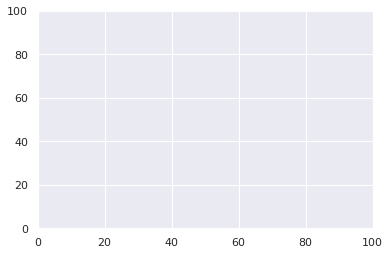

In [198]:
import matplotlib
#matplotlib.use('Qt5Agg') #use Qt5 as backend, comment this line for default backend

from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()

ax = plt.axes(xlim=(0, 100), ylim=(0, 100))

#lines = [plt.plot([], [])[0] for _ in range(N)] #lines to animate
lines = ax.plot([], [], marker="o", markersize=5, color=np.random.random(3), markerfacecolor=np.random.random(3))

plt.show()
def init():
    #init lines
    line.set_data([], [])

    return (lines) #return everything that must be updated

def animate(i):
    #animate lines
    #line.set_data([0, 2], [10 * j,i])
    for j in range(ajot_len):
        x = df_reitit[df_reitit["ajokerta"] == j]['x']
        y = df_reitit[df_reitit["ajokerta"] == j]['y']
        line.set_data(x[:i], y[:i])

    return (lines) #return everything that must be updated


anim = animation.FuncAnimation(fig, animate, init_func=init,frames=100, interval=20, blit=True)

anim.save('kakka.gif', writer='pillow', fps=60)
plt.show()

ValueError: 'c' argument has 1065 elements, which is not acceptable for use with 'x' with size 1066, 'y' with size 1066.

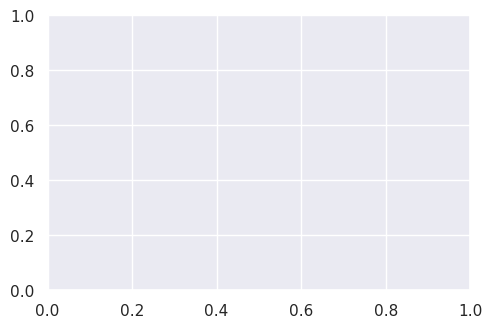

In [158]:
x = df_reitit[df_reitit["ajokerta"] == 3]['x'].values
y = df_reitit[df_reitit["ajokerta"] == 3]['y'].values

import matplotlib.pyplot as plt

import numpy as np
from matplotlib import collections  as mc
from scipy.interpolate import interp1d
from matplotlib.colors import colorConverter

def colored_line_segments(xs,ys,color,mid_colors=False):
    if isinstance(color,str):
        color = colorConverter.to_rgba(color)[:-1]
        color = np.array([color for i in range(len(xs))])        
    segs = []
    seg_colors = []    
    lastColor = [color[0][0],color[0][1],color[0][2]]    
    start = [xs[0],ys[0]]
    end = [xs[0],ys[0]]        
    for x,y,c in zip(xs,ys,color):
        if mid_colors:
            seg_colors.append([(chan+lastChan)*.5 for chan,lastChan in zip(c,lastColor)])        
        else:   
            seg_colors.append(c)        
        lastColor = [c[0],c[1],c[2]]            
        start = [end[0],end[1]]
        end = [x,y]
        segs.append([start,end])
    colors = [(*color,1) for color in seg_colors]
    lc = mc.LineCollection(segs, colors=colors)
    return lc, segs, colors

def segmented_resample(xs,ys,color,n_resample=100,mid_colors=False):    
    n_points = len(xs)
    if isinstance(color,str):
        color = colorConverter.to_rgba(color)[:-1]
        color = np.array([color for i in range(n_points)])   
    n_segs = (n_points-1)*(n_resample-1)        
    xsInterp = np.linspace(0,1,n_resample)
    segs = []
    seg_colors = []
    hiResXs = [xs[0]]
    hiResYs = [ys[0]]
    RGB = color.swapaxes(0,1)
    for i in range(n_points-1):
        fit_xHiRes = interp1d([0,1],xs[i:i+2])
        fit_yHiRes = interp1d(xs[i:i+2],ys[i:i+2])
        
        xHiRes = fit_xHiRes(xsInterp)
        yHiRes = fit_yHiRes(xHiRes)    
        
        hiResXs = hiResXs+list(xHiRes[1:])
        hiResYs = hiResYs+list(yHiRes[1:])
        
        R_HiRes = interp1d([0,1],RGB[0][i:i+2])(xHiRes)        
        G_HiRes = interp1d([0,1],RGB[1][i:i+2])(xHiRes)      
        B_HiRes = interp1d([0,1],RGB[2][i:i+2])(xHiRes)       
                        
        lastColor = [R_HiRes[0],G_HiRes[0],B_HiRes[0]]        
        
        start = [xHiRes[0],yHiRes[0]]
        end = [xHiRes[0],yHiRes[0]]
        if mid_colors: seg_colors.append([R_HiRes[0],G_HiRes[0],B_HiRes[0]])
        for x,y,r,g,b in zip(xHiRes[1:],yHiRes[1:],R_HiRes[1:],G_HiRes[1:],B_HiRes[1:]):
            if mid_colors:
                seg_colors.append([(chan+lastChan)*.5 for chan,lastChan in zip((r,g,b),lastColor)])
            else:            
                seg_colors.append([r,g,b])
            
            lastColor = [r,g,b]            
            start = [end[0],end[1]]
            end = [x,y]
            segs.append([start,end])

    colors = [(*color,1) for color in seg_colors]    
    return segs, colors, [hiResXs,hiResYs]        

def faded_segment_resample(xs,ys,color,fade_len=20,n_resample=100,direction='Head'):      
    segs, colors, hiResData = segmented_resample(xs,ys,color,n_resample)    
    n_segs = len(segs)   
    if fade_len>len(segs):
        fade_len=n_segs    
    if direction=='Head':
        #Head fade
        alphas = np.concatenate((np.zeros(n_segs-fade_len),np.linspace(0,1,fade_len)))
    else:        
        #Tail fade
        alphas = np.concatenate((np.linspace(1,0,fade_len),np.zeros(n_segs-fade_len)))
    colors = [(*color[:-1],alpha) for color,alpha in zip(colors,alphas)]
    lc = mc.LineCollection(segs, colors=colors)
    return segs, colors, hiResData 

    
if __name__ == "__main__":

    NPOINTS = 1066
    RESAMPLE = 1066
    N_FADE = int(RESAMPLE*NPOINTS*0.5)
    N_SEGS = (NPOINTS-1)*(RESAMPLE-1)  

    SHOW_POINTS_AXI_12 = True
    SHOW_POINTS_AXI_34 = True

    np.random.seed(11)
    xs = df_reitit[df_reitit["ajokerta"] == 3]['x'].values
    ys = df_reitit[df_reitit["ajokerta"] == 3]['y'].values

    COLOR='b'

    MARKER = '.'
    #MARKER_COLOR = 'k'
    CMAP = plt.get_cmap('hsv')
    COLORS = np.array([CMAP(i)[:-1] for i in np.linspace(0,1,NPOINTS)])
    MARKER_COLOR = COLORS
    
    N_SCATTER = (NPOINTS-1)*(RESAMPLE-1)+1
    COLORS_LONG = np.array([CMAP(i)[:-1] for i in np.linspace(1/N_SCATTER,1,N_SCATTER)])

    fig = plt.figure(figsize=(12,8),dpi=100)
    ax1 = fig.add_subplot(221) # original data
    lc, segs, colors = colored_line_segments(xs,ys,COLORS,True)
    if SHOW_POINTS_AXI_12: ax1.scatter(xs,ys,marker=MARKER,color=COLORS)
    ax1.add_collection(lc)
    ax1.text(.05,1.05,'Original Data')
    ax1.set_ylim(0,1.2)

    ax2 = fig.add_subplot(222, sharex=ax1, sharey=ax1) # resampled data
    segs, colors, hiResData   = segmented_resample(xs,ys,COLORS,RESAMPLE)
    if SHOW_POINTS_AXI_12: ax2.scatter(hiResData[0],hiResData[1],marker=MARKER,color=COLORS_LONG)
    ax2.add_collection(mc.LineCollection(segs, colors=colors))
    ax2.text(.05,1.05,'Original Data - Resampled')
    ax2.set_ylim(0,1.2)

    ax3 = fig.add_subplot(223, sharex=ax1, sharey=ax1) # resampled with linear alpha fade start to finish

    segs, colors, hiResData = faded_segment_resample(xs,ys,COLORS,fade_len=RESAMPLE*NPOINTS,n_resample=RESAMPLE,direction='Head')
    if SHOW_POINTS_AXI_34: ax3.scatter(hiResData[0],hiResData[1],marker=MARKER,color=COLORS_LONG)
    ax3.add_collection(mc.LineCollection(segs, colors=colors))
    ax3.text(.05,1.05,'Resampled - w/Full length fade')
    ax3.set_ylim(0,1.2)

    ax4 = fig.add_subplot(224, sharex=ax1, sharey=ax1) # resampled with linear alpha fade N_FADE long
    segs, colors, hiResData = faded_segment_resample(xs,ys,COLORS,fade_len=N_FADE,n_resample=RESAMPLE,direction='Head')
    if SHOW_POINTS_AXI_34: ax4.scatter(hiResData[0],hiResData[1],marker=MARKER,color=COLORS_LONG)
    ax4.add_collection(mc.LineCollection(segs, colors=colors))
    ax4.text(.05,1.05,'Resampled - w/{} point fade'.format(N_FADE))
    ax4.set_ylim(0,1.2)

    plt.show()

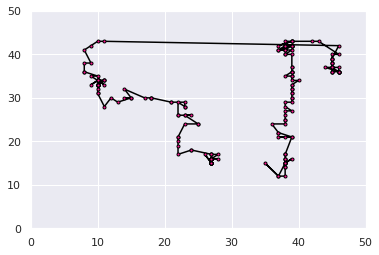

In [28]:
%matplotlib inline



#Linestyle	Description
#'-' or 'solid'	solid line
#'--' or 'dashed'	dashed line
#'-.' or 'dashdot'	dash-dotted line
#':' or 'dotted'	dotted line
#'None' or ' ' or ''	draw nothing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Suositus 1 node ja esim 1 päivän plot
#x = df_reitit[df_reitit["ajokerta"] == 3]['x']
#y = df_reitit[df_reitit["ajokerta"] == 3]['y']

fig, ax = plt.subplots()
#ax.set_xlim((0, 100))
#ax.set_ylim((0, 100))
line, = ax.plot([], [], marker="o", markersize=3, color='black', markerfacecolor='deeppink')
#plt.scatter(x, y, c=t, cmap='jet')

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = df_reitit[df_reitit["ajokerta"] == 7]['x']
    y = df_reitit[df_reitit["ajokerta"] == 7]['y']
    line.axes.axis([0, 50, 0, 50])
    line.set_data(x[:i], y[:i])
    #line.axes.axis([-2000, 6000, -2000, 5000])
    return (line,)

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(x),
                              interval=20, blit=True)
#plt.show()
ani.save('reitti.gif', writer='pillow', fps=60)
ani

In [31]:
df_reitit

,ajokerta,node_id,timestamp,x,y,grid_id,velocity_kmh,distance_grid,kesto
0,1,1,2020-06-24 15:20:14.482,31,9,391,0.575621,0,00:04:45.618000
1,1,1,2020-06-24 15:20:15.659,33,8,353,1.392523,2,00:04:45.618000
2,1,1,2020-06-24 15:20:15.837,33,8,353,0.882022,0,00:04:45.618000
3,1,1,2020-06-24 15:20:17.590,35,8,355,0.928694,2,00:04:45.618000
4,1,1,2020-06-24 15:20:21.982,37,11,477,0.760018,5,00:04:45.618000
...,...,...,...,...,...,...,...,...,...
95,69,1,2020-07-07 16:27:53.793,15,11,455,0.044200,0,00:03:20.998000
96,69,1,2020-07-07 16:27:59.793,15,10,415,0.075000,0,00:03:20.998000
97,69,1,2020-07-07 16:27:59.795,15,10,415,2.890000,0,00:03:20.998000
98,69,1,2020-07-07 16:28:01.793,15,9,375,0.412412,1,00:03:20.998000


In [34]:
df_reitit[df_reitit["ajokerta"] == 1]['distance_grid']
df_reitit.groupby(["ajokerta"])["distance_grid"].sum()

ajokerta
1     210
2     350
3     103
4     462
5     161
     ... 
64    104
66     89
67    132
68    135
69     93
Name: distance_grid, Length: 65, dtype: int64

In [35]:
df_reitit.groupby(["ajokerta"])["velocity_kmh"].mean()

ajokerta
1     1.137495
2     0.803736
3     1.026219
4     1.224285
5     0.925309
        ...   
64    0.996895
66    1.150145
67    1.060939
68    1.233059
69    1.037129
Name: velocity_kmh, Length: 65, dtype: float64

Ajokerrat:  69


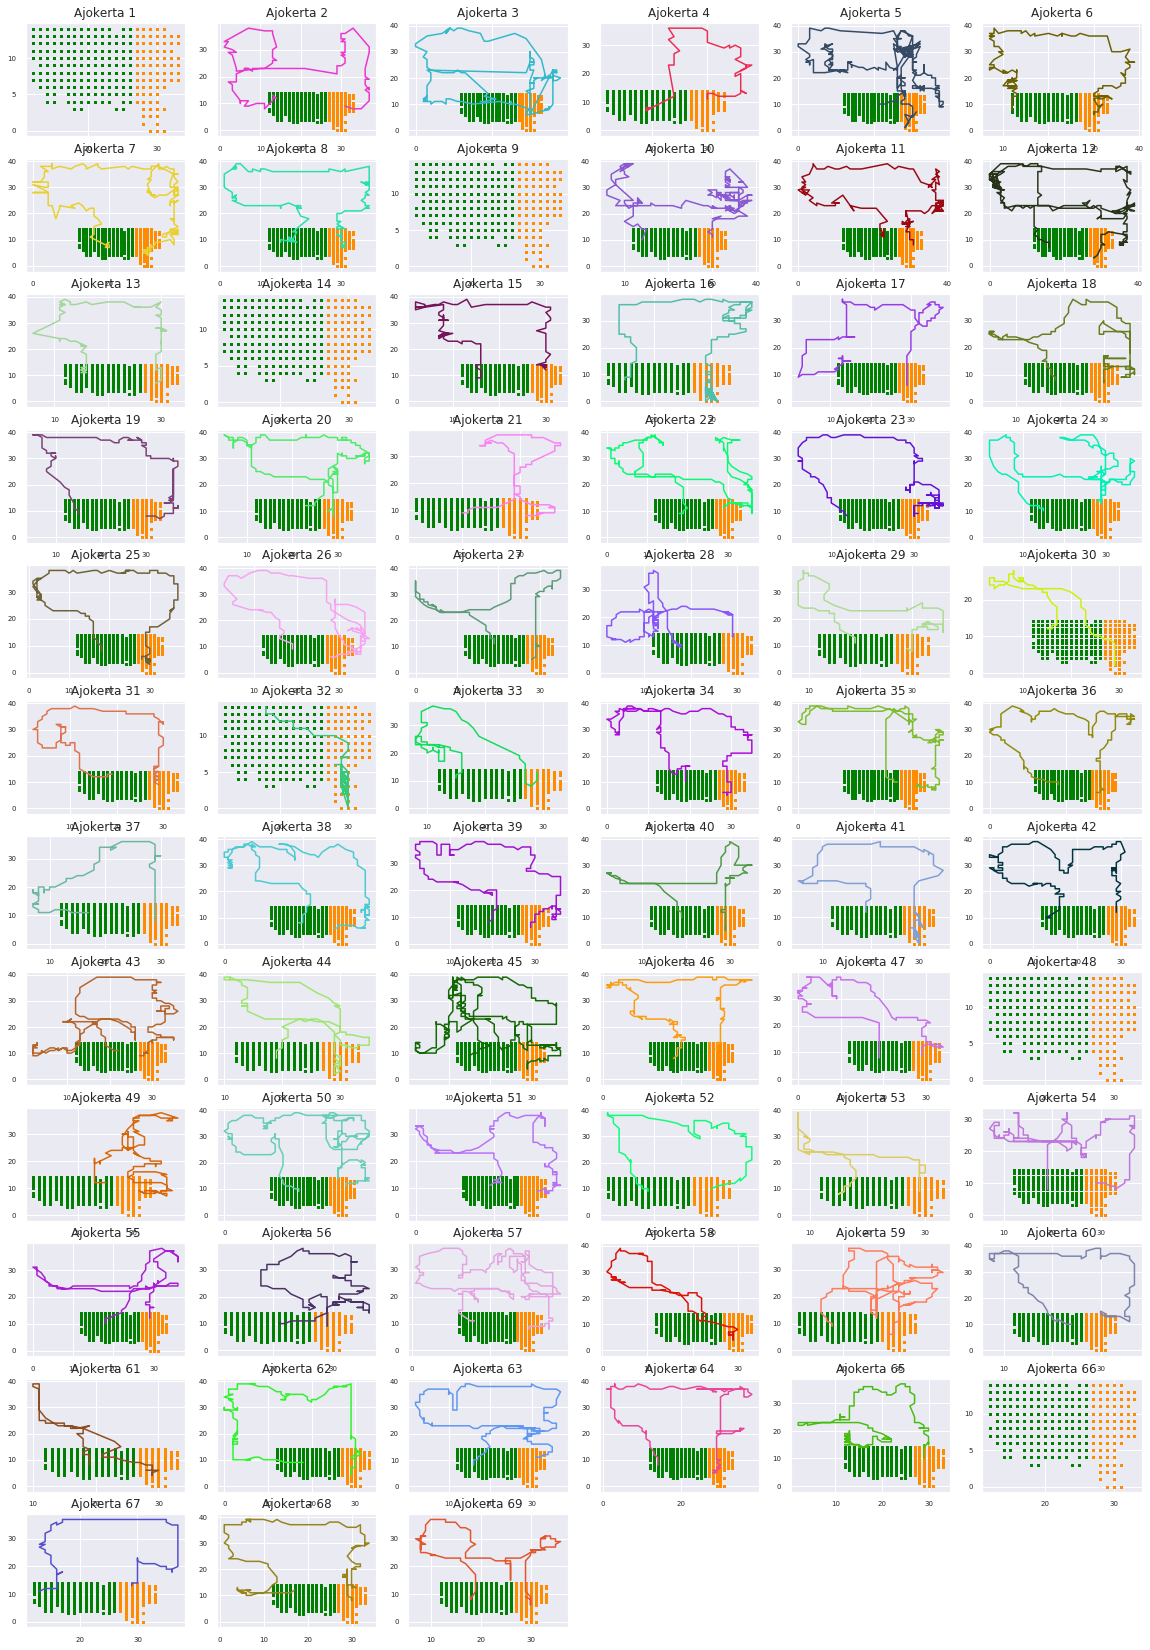

CPU times: user 1min, sys: 3.47 s, total: 1min 4s
Wall time: 21.8 s


In [110]:
%%time

import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

def draw_route_grid(df):
    ajot = df["ajokerta"].unique()
    ajot_len = max(df["ajokerta"].unique())

    #c = cm.flag(np.linspace(0, 1, ajot_len))
    all_colors = [k for k,v in pltc.cnames.items()]

    print("Ajokerrat: ",ajot_len)
    if ajot_len > 10:
        plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size
    elif ajot_len < 10:
        plt.figure(figsize=(20,ajot_len))


    for i in range(ajot_len):
        c = sample(all_colors, ajot_len)
        plt.subplot((ajot_len/5)+1,6,i+1)
        plt.plot(df[df["ajokerta"] == i]['x'], df[df["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
        plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
        plt.scatter(out_x, out_y, color='green', marker='s', s=2)
        plt.title(f"Ajokerta {i+1}")
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        #plt.xlim(0, 40)
        #plt.ylim=(0, 40)
        #plt.axis('off')

    plt.show()

draw_route_grid(df_reitit)

Ajokerrat:  60


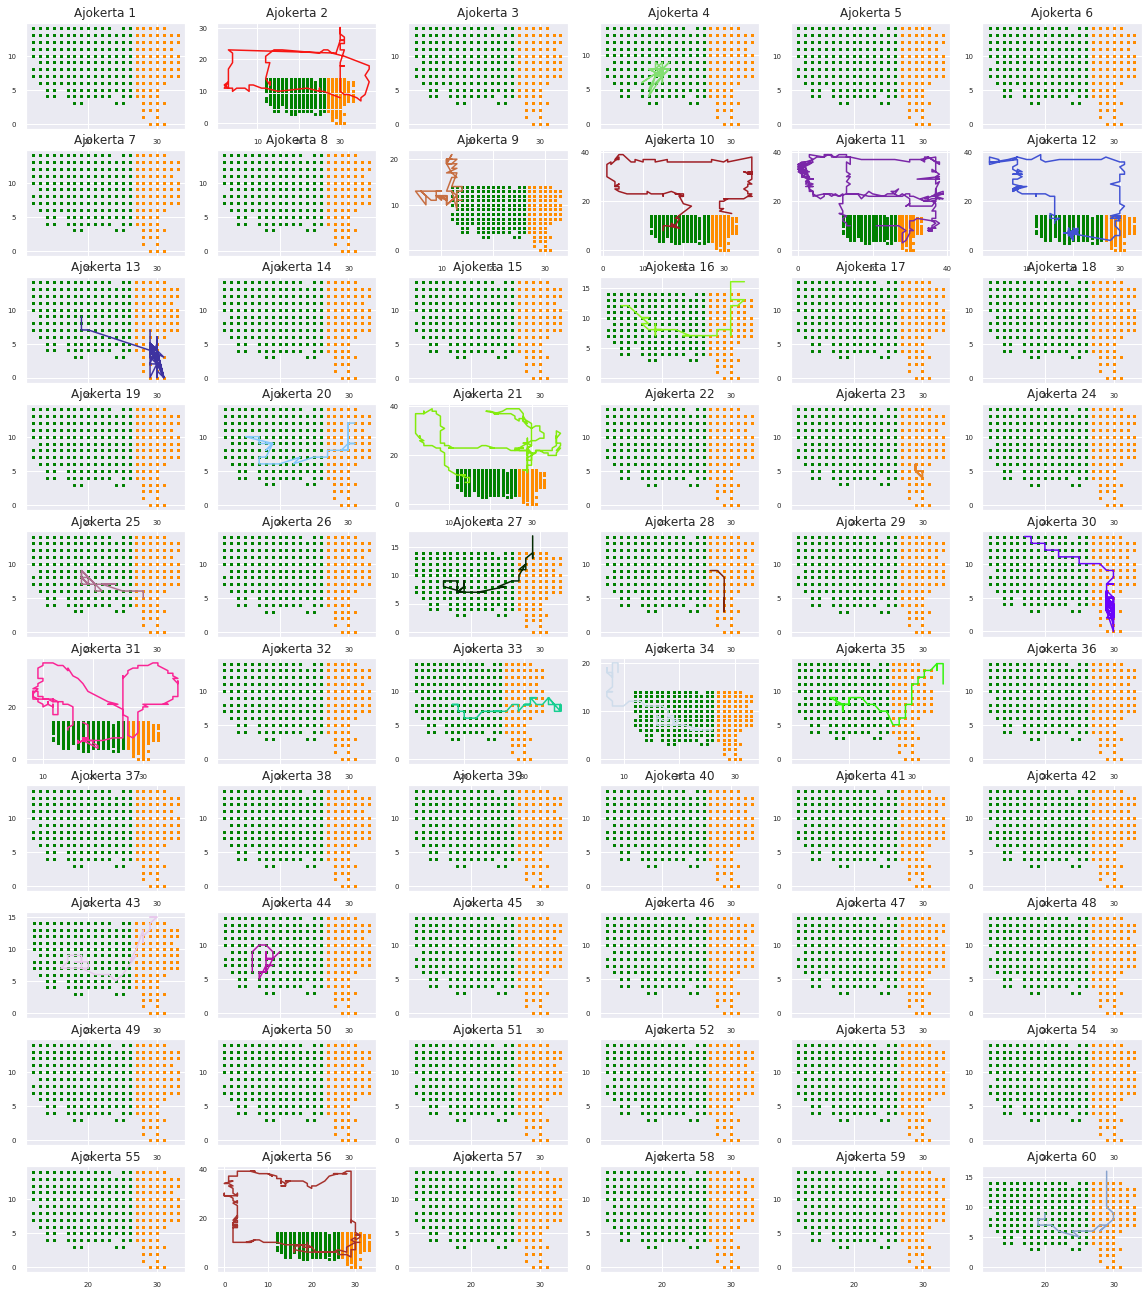

CPU times: user 1min 6s, sys: 3.9 s, total: 1min 10s
Wall time: 23.9 s


In [38]:
%%time

import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

ajot = df_reitit["ajokerta"].unique()
ajot_len = max(df_reitit["ajokerta"].unique())

#c = cm.flag(np.linspace(0, 1, ajot_len))
all_colors = [k for k,v in pltc.cnames.items()]

print("Ajokerrat: ",ajot_len)
if ajot_len > 10:
    plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size
elif ajot_len < 10:
    plt.figure(figsize=(20,ajot_len))


for i in range(ajot_len):
    c = sample(all_colors, ajot_len)
    plt.subplot((ajot_len/5)+1,6,i+1)
    plt.plot(df_reitit[df_reitit["ajokerta"] == i]['x'], df_reitit[df_reitit["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
    plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
    plt.scatter(out_x, out_y, color='green', marker='s', s=2)
    plt.title(f"Ajokerta {i+1}")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    #plt.axis('off')

plt.show()

983


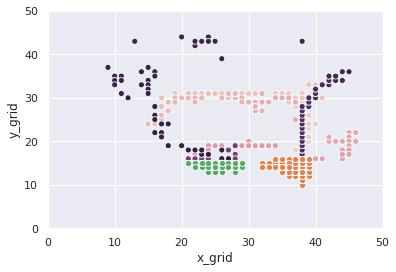

296


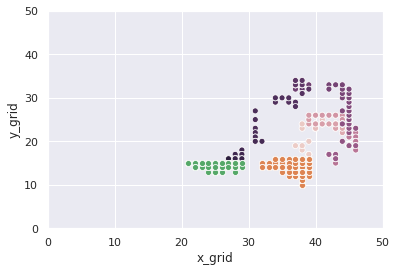

285


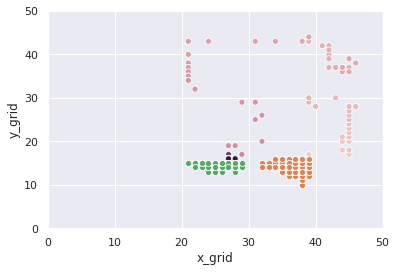

110


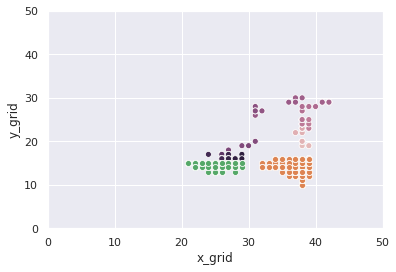

530


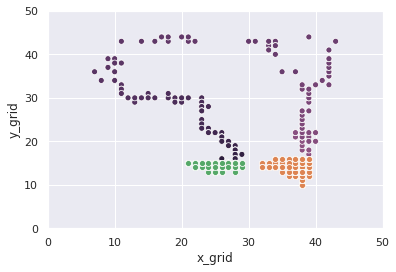

414


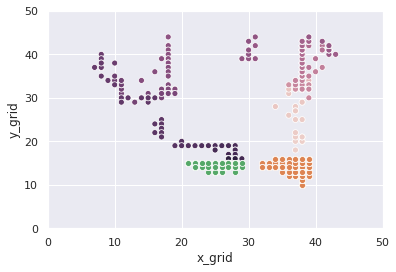

237


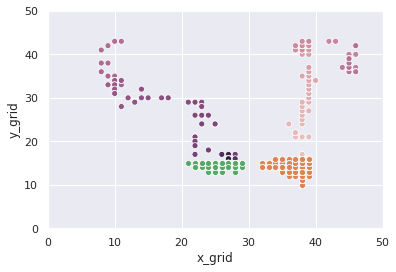

2124


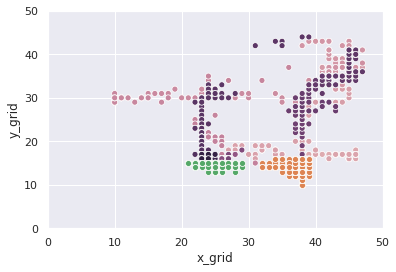

71


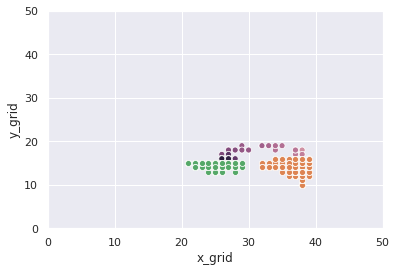

157


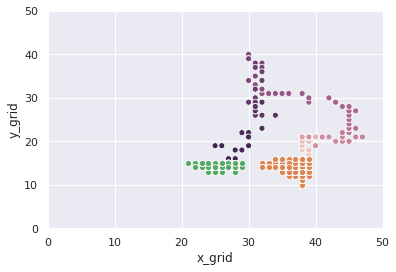

2835


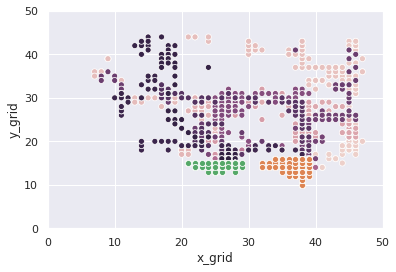

537


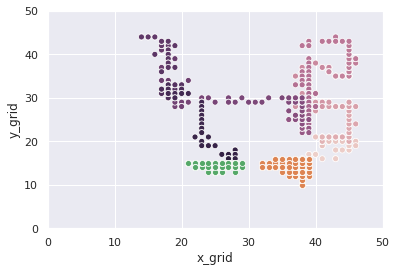

354


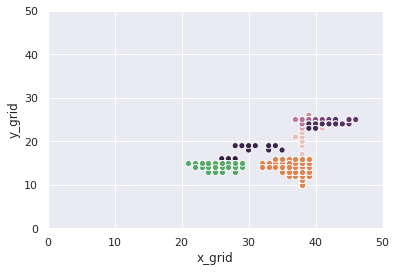

339


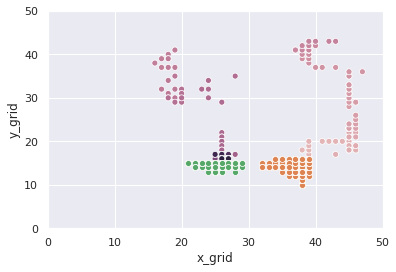

284


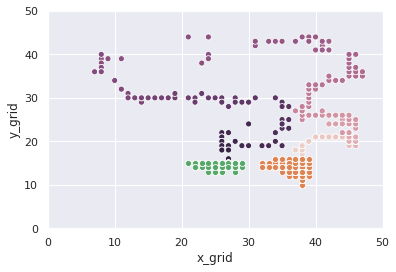

179


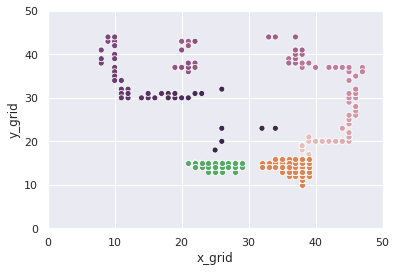

836


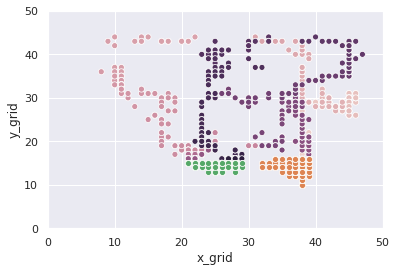

720


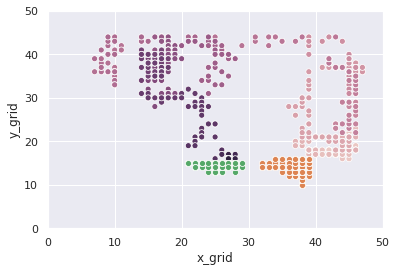

266


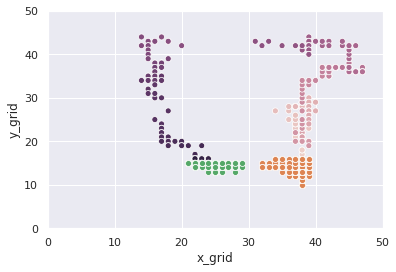

226


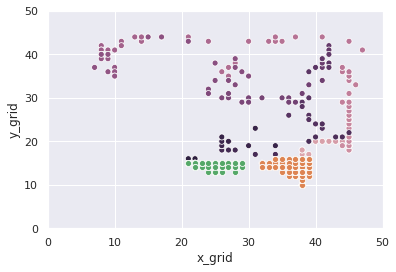

5095


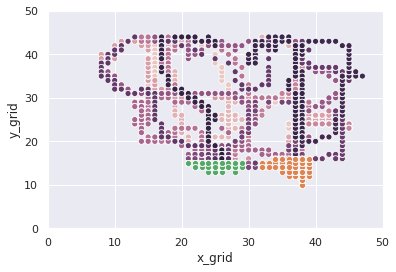

CPU times: user 41.8 s, sys: 3.08 s, total: 44.9 s
Wall time: 6.81 s


In [37]:
%%time
# Plottaa jokaisen kauppareissut erikseen.
plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä